# Sentiment Analysis of political leaders' tweets during the 2022 election campaign
**Abstract:**<br>
This project aims to analyse the tweets written by political leaders during the most recent campaign for the Parlamental election, which was held on Sunday, 25th September 2022. The goal is to detect the general tone of voice of such tweets, in order to understand the general sentiment behind the text posts, as well as checking for the presence of multiple topics among these posts. To do so, we first collected a total of 2.829 tweets among six political leaders in the span of two months. Then, we retrieved the more relevant text information through the Term Frequency-Inverse Document Frequency (TF-IDF) method. Finally, we analysed the most-recurring keywords through the topic-modelling, Latent Dirichlet Analysis model.
<br> <br>
**General Information**<br>
**Starting date of tweet collection:** 21st July 2022, day when the Parliament chambers were disbanded<br>
**Final date of tweet collection:** 25th September 2022, day of the election<br>
**Tweet language:** Italian<br>
**Analysed leaders:** Giorgia Meloni (Fratelli d'Italia/FdI, right-wing), Matteo Salvini (Lega, right-wing), Silvio Berlusconi (Forza Italia/FI, right-wing), Enrico Letta (Partito Democratico/PD, left-wing), Matteo Renzi (Italia Viva/IV, left-wing), Carlo Calenda (Azione, left-wing), Luigi Di Maio (Impegno Civico, left-wing), Giuseppe Conte (Movimento5Stelle/M5S, no political leaning) 

## Import modules

In [1]:
from src.get_tweets import get_tweets_df
from src.nlp_class import *
from src.text_mining_class import *
from src.plots_class import *
from src.params import *
import warnings
warnings.filterwarnings('ignore')

## Initialize Data
* Import dataset of Tweets created before the elections (a dataset of the tweets created in the two months after the election is also present, but unnecessary)
* Initialize Python classes for Natural Language Processing, text mining, Plot/Graph drawing
* Plot chronological distribution of tweets

Collected 2829 tweets during the electoral campaign


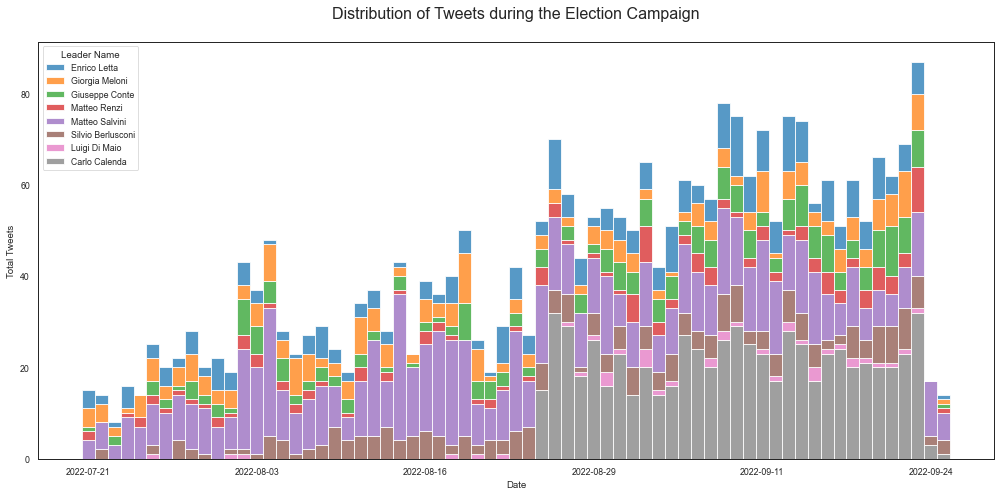

In [2]:
# set up twitter 
tweets_df, _ = get_tweets_df(concat=False)
#tweets_df = get_tweets_df()

# initialize classes
nlp = NLPClassifier()           # Natural Language Processing
mining = TextMining(ngram=1)    # Text Mining
P = PlotsClass()                # Plots/Graphs


# plot chronological distribution of tweets throughout the campaign
P.plot_tweet_chrono(tweets_df, save=False)

The number of published tweets increased as the election date grew nearer, also thanks to a candidate who joined Twitter at the end of August. The exception of the last two days (24th-25th of September) is due to the "electoral silence" held by the candidates, i.e. they were forbidden to campaign the day before and the day of the election.

## Process the Tweet dataset
### Clean and tokenize the 'Text' column
* Clean the text from stopwords, punctuation, and external links
* Find the compound polarity of the text
* Tokenize the cleaned text and return it into a new column ('Tokenized_Text')

In [3]:
tweets_df = nlp.process_text_col(tweets_df, stem=False, lem = False, min_len=3)
# show df with cleaned, tokenized text
tweets_df.head()


,Date,Tweet ID,Leader Name,Followers,Text,Hashtags,Polarity Score,Tokenized Text
0,2022-09-25,1573900648617213954,Giorgia Meloni,1762356,Oggi puoi contribuire a scrivere la storia 🇮🇹 ...,[],0.4019,"[contribuire, scrivere, storia]"
1,2022-09-23,1573425452101820421,Giorgia Meloni,1762356,"Chi sogna un’Italia orgogliosa, chi vuole torn...","[VotaFDI, Meloni]",0.8750,"[sogna, italia, orgogliosa, tornare, fiero, na..."
2,2022-09-23,1573406879497199617,Giorgia Meloni,1762356,"Al Sud, come in tutta Italia, c’è voglia di re...","[pronti, ElezioniPolitiche2022, VotaFDI, Meloni]",0.8519,"[sud, italia, voglia, reale, cambiamento, pron..."
4,2022-09-23,1573372128183070720,Giorgia Meloni,1762356,Votando @FratellidItalia uscirete dalla cabina...,"[VotaFDI, Meloni]",0.9563,"[votando, fratelliditalia, uscirete, cabina, l..."
5,2022-09-23,1573308373009039360,Giorgia Meloni,1762356,"Abbiamo riempito le piazze in tutta Italia, da...","[25settembre, VAIaVOTARE, VotaFDI, Meloni]",0.3595,"[riempito, piazze, italia, nord, sud, arrivato..."


Summary of the number of tweets and average polarity score:

In [4]:
tot_twts = {leader: tweets_df[tweets_df["Leader Name"]==leader].shape[0] for leader in party_leaders.keys()}
pol_scores = {leader: round(tweets_df[tweets_df["Leader Name"]==leader]["Polarity Score"].mean(),3) for leader in party_leaders.keys()}

d = {l: [int(tot_twts[l]), pol_scores[l]] for l in tot_twts.keys()}
d = pd.DataFrame(d, index=['Total Tweets', 'Average Polarity Score'])
d.T


,Total Tweets,Average Polarity Score
Giorgia Meloni,258.0,0.174
Matteo Salvini,818.0,0.218
Silvio Berlusconi,250.0,0.265
Enrico Letta,282.0,0.188
Carlo Calenda,615.0,0.075
Matteo Renzi,135.0,0.262
Luigi Di Maio,35.0,0.061
Giuseppe Conte,194.0,0.201


### Vectorization and Feature Extraction
* Vectorize the tokenized text and return the sparse matrix
* Extract the feature names from the TF-IDF vectorizer
* Extract the keywords from the tokenized text
* Return the total of keywords found and the remaining documents

In [5]:
only_text = tweets_df['Tokenized Text'].apply(lambda x: " ".join(x))
vectorized_text = mining.vectorized_text(only_text.values.tolist())     # sparse matrix
features_names = mining.get_features_names()                            # feature names

top_keywords = 500
filtered_words = mining.extract_topn_from_vector(features_names, mining.sort_coo(vectorized_text), top_keywords)
filtered_words_set = set(map(str.lower, set(filtered_words)))

tokenized_kw = nlp.extract_keywords_from_tweets(only_text, filtered_words_set, min_len = 2)

Shape of Sparse Matrix (2587, 9988), type: <class 'scipy.sparse._csr.csr_matrix'>
Keywords found: 431
Remaining documents: 336


In [6]:
vectorized_text_kw = mining.vectorized_text([' '.join(x) for x in tokenized_kw])
freq_dist_tweets= nlp.frequency_dist(tokenized_kw, obj='other')

Shape of Sparse Matrix (336, 272), type: <class 'scipy.sparse._csr.csr_matrix'>


### Tweet Semantic graph
* Create graph with keywords occurring at least 5 times
* Check nodes with highest degree and betweenness centrality

In [7]:
min_occurencies = 5
main_word_graph =  P.graph_filtered_dist(tokenized_kw, freq_dist_tweets, min_occurencies, obj='other') 

degree_centrality = nx.algorithms.centrality.degree_centrality(main_word_graph)
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(main_word_graph)
centrality = [betweenness_centrality, degree_centrality]

print(f"Number of nodes: {len(main_word_graph)}")

Number of nodes: 48


Keep only connected components

In [8]:
min_degree = 5
top_centrality_word =30

graph_min_degree=P.keep_min_degree(main_word_graph,min_degree)
top_words_min = P.get_set_top_words(centrality, top_centrality_word)
top_words_ext = P.extend_top_word(graph_min_degree,threshold=10, res=top_words_min)
# Keep only the connected components
P.keep_connected_components(graph_min_degree, min_deg=min_degree)

print(f"Number of words kept: {len(top_words_ext)}")

Number of words kept: 35


In [9]:
density = nx.classes.function.density(graph_min_degree)

n_ties = len(graph_min_degree.edges())
tot_ties= len(graph_min_degree)*(len(graph_min_degree)-1)
avg_deg= n_ties/tot_ties

print(f"Network density: {round(density,3)}")
print(f"Average degree: {round(avg_deg,3)}")

Network density: 0.259
Average degree: 0.13


The network density meter reports that almost one in three connections between two nodes is an actual connection, i.e. the keywords are actually related.
The low average degree, however, shows that most nodes have only a single connection between each other.

Choose the ideal cluster parameters:

In [10]:
for i in [1,2,3,5,10,20,25]: 
    P.spectral_clustering(graph_min_degree,n_cluster=2, w='count', k=i)

Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069
Cluster distribution: [33, 14]	Silhouette score: 0.1069


Cluster the graph:

In [23]:
n_clust,k,gamma = 2,3,5
cluster, cluster_labels = P.spectral_clustering(graph_min_degree, n_clust, w="count",k=k, gamma=gamma)
#plot_clust = P(graph=graph_min_degree,freq_dist=freq_dist_tweets,labels= cluster_labels)  # for all 3 params the object is not callable
# con NetworkPlot() funziona = il problema è nella classe P, non nei params

Cluster distribution: [4, 43]	Silhouette score: 0.5356


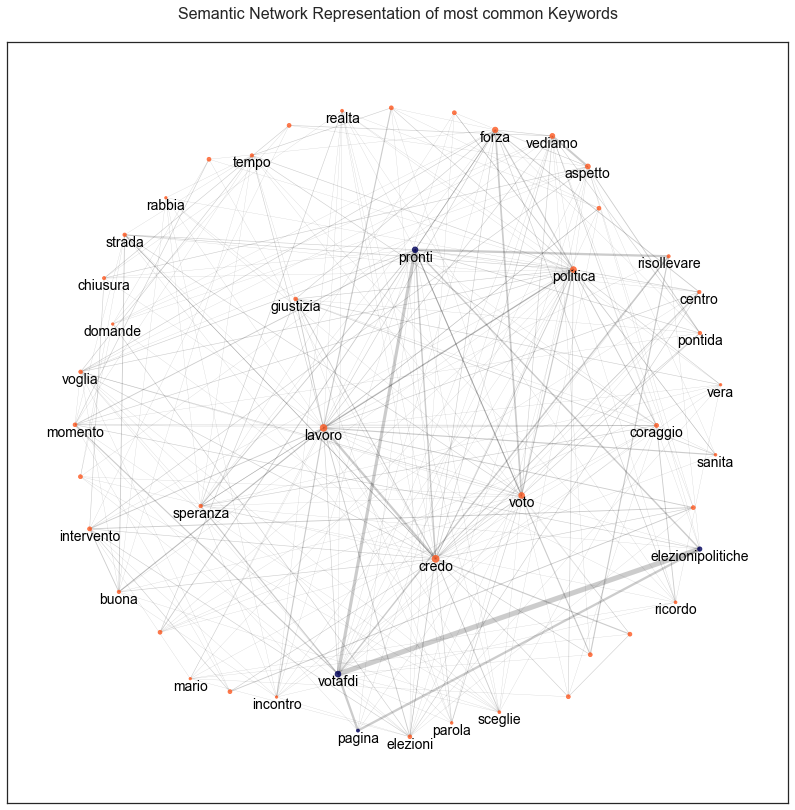

In [24]:
colors = ['#03045e', '#FE5D26', '#218380', '#D72483', '#F2D0A4', '#FD3E81']
P.plot_main_centrality( graph= graph_min_degree,
                        res= top_words_ext, 
                        freq_dist = freq_dist_tweets,
                        mult_factor=1,
                        labels_ = cluster_labels,
                        save=False, 
                        k=5.5, 
                        i=100, 
                        w=None, ka=False, 
                        c=colors, a=.2)#, s=10)

### LDA - Latent Dirichlet Allocation

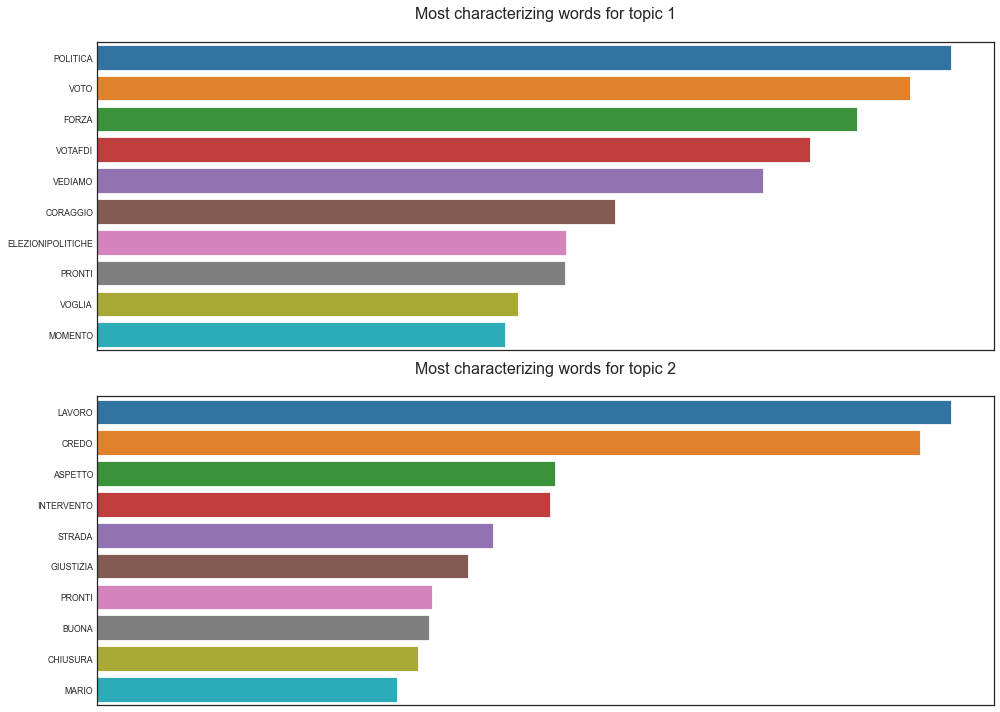

In [13]:
topics, top_word = 2,10
lda_model = mining.lda_topic_modelling(vectorized_text_kw, topics) # count_vector?
P.plot_lda_topic(lda_model, topics, cls=mining, n_top_words=top_word, save=False)


### LDA Wordcloud

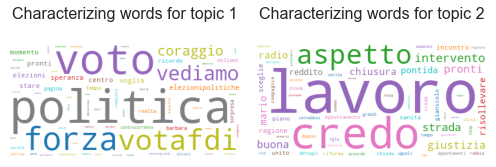

In [14]:
wordcloud_words = mining.word_cloud_dict(lda_model)
P.plot_wordcloud(wordcloud_words, save=False)